In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.insert(0, '..')
import torch
import torch.nn as nn
import torch.optim as optim
from simplest_net import SimpleNN
from glucose_dataset import GlucoseDataset
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Load the dataset and loader
glucose_dataset = GlucoseDataset("../datasets/diabetes_datasets.zip", sub_directory="Shanghai_T1DM")
print(f"Dataset size: {len(glucose_dataset)}")

# Determine the size of the training and testing sets
p_test = 0.2

# Split the dataset into training and testing sets
ds_train, ds_test = random_split(glucose_dataset, [1 - p_test, p_test])
print(f"Training set size: {len(ds_train)}")
print(f"Testing set size: {len(ds_test)}")

# Create DataLoader instances for training and testing
batch_size = 32
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, pin_memory=True)

Dataset size: 15407
Training set size: 12326
Testing set size: 3081


In [3]:
# Define the dimensions of your input, hidden, and output layers
input_size = glucose_dataset.input_length  # Adjust this based on your input features
hidden_size = glucose_dataset.input_length * 4  # Adjust this based on your desired hidden layer size
output_size = glucose_dataset.output_length  # Adjust this based on your output size
print(input_size, hidden_size, output_size)

num_epochs = 50  # Adjust this based on your desired number of training epochs

# Create an instance of the SimpleNN model
model = SimpleNN(input_size, hidden_size, output_size).to(device)
print(model)

16 64 1
SimpleNN(
  (fc1): Linear(in_features=16, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [4]:
# Define a loss function (Mean Squared Error is commonly used for regression tasks)
criterion = nn.MSELoss()

# Define an optimizer (e.g., Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
loss_history = []

# Assuming you have a DataLoader named 'train_dataloader' for training samples
# Iterate through your dataset for training
best_loss = 1e9
for epoch in tqdm(range(num_epochs)):
    # Train on the current epoch
    for inputs, targets in dl_train:
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the test set for loss
    running_loss = 0.0
    for inputs, targets in dl_test:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
    if running_loss < best_loss:
        best_loss = running_loss
        torch.save(model.state_dict(), "best_model.pth")
    
    loss_history.append(running_loss / len(dl_test))

# After training, you can use the model to make predictions
# For example, assuming 'input_data' is a tensor with shape [batch_size, input_size]
input_data = torch.randn((32, input_size))  # Example random input data
predicted_values = model(input_data)

  0%|          | 0/50 [00:00<?, ?it/s]

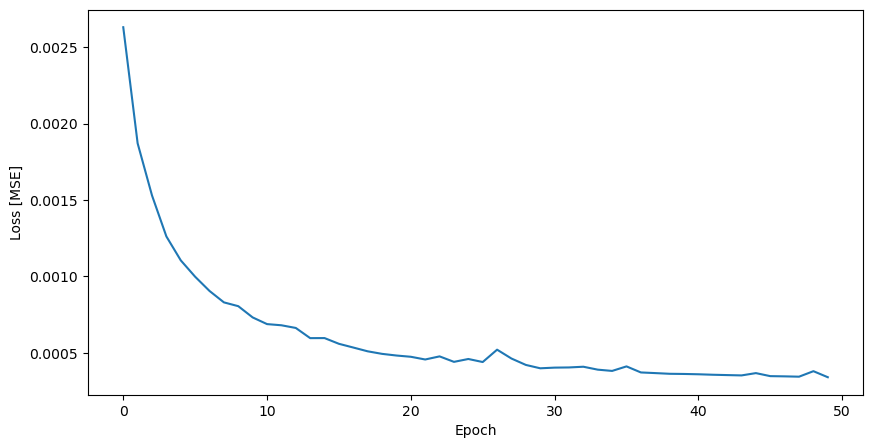

<Figure size 640x480 with 0 Axes>

In [5]:
# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss [MSE]")
plt.show()
plt.tight_layout()

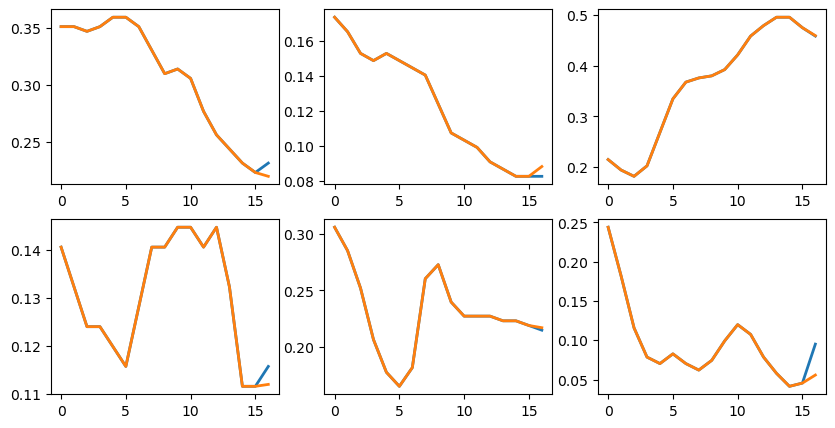

In [6]:
# Display some of the test batch predictions
inputs, targets = next(iter(dl_test))
outputs = model(inputs).detach()

# Plot the first 6 test batch predictions
plt.figure(figsize=(10, 5))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    
    # Construct the sample and prediction data
    estimated_sample = np.append(inputs[i].numpy(), outputs[i].numpy())
    original_sample = np.append(inputs[i].numpy(), targets[i].numpy())

    # Plot the sample and prediction data
    plt.plot(original_sample, label="Original", lw=2)
    plt.plot(estimated_sample, label="Estimated", lw=2)